In [1]:
from sklearn.datasets import fetch_20newsgroups_vectorized

In [3]:
news20_trn = fetch_20newsgroups_vectorized(subset='train',
                                           remove=('headers', 'footers', 'quotes'), 
                                           data_home="data/news20")
news20_tst = fetch_20newsgroups_vectorized(subset='test', 
                                           remove=('headers', 'footers', 'quotes'), 
                                           data_home="data/news20")

In [5]:
import pickle

In [6]:
with open('data/news20/news20.pkl', 'wb') as f:
    pickle.dump(news20_trn, f, -1)
    pickle.dump(news20_tst, f, -1)

In [98]:
with open('data/news20/news20.pkl', 'rb') as f:
    news20_trn = pickle.load(f)
    news20_tst = pickle.load(f)
X_trn, y_trn = news20_trn.data, news20_trn.target
X_tst, y_tst = news20_tst.data, news20_tst.target

In [2]:
target_names = news20_tst.target_names
target_num = len(target_names)
target_supports = [sum(y_tst == target) for target in range(target_num)]

In [3]:
for i in range(target_num):
    print('{}\t{}\t{}'.format(i, target_names[i], target_supports[i]))

0	alt.atheism	319
1	comp.graphics	389
2	comp.os.ms-windows.misc	394
3	comp.sys.ibm.pc.hardware	392
4	comp.sys.mac.hardware	385
5	comp.windows.x	395
6	misc.forsale	390
7	rec.autos	396
8	rec.motorcycles	398
9	rec.sport.baseball	397
10	rec.sport.hockey	399
11	sci.crypt	396
12	sci.electronics	393
13	sci.med	396
14	sci.space	394
15	soc.religion.christian	398
16	talk.politics.guns	364
17	talk.politics.mideast	376
18	talk.politics.misc	310
19	talk.religion.misc	251


In [4]:
clfs = []

from sklearn import naive_bayes as nb 
clfs.append(nb.BernoulliNB(alpha=1e-14))
clfs.append(nb.MultinomialNB(alpha=1e-3))

from sklearn import svm
clfs.append(svm.LinearSVC(C=4, penalty='l1', dual=False))
clfs.append(svm.LinearSVC(C=2, penalty='l2', dual=False))

In [5]:
#clf_names = ['NB_Bern', 'NB_Mult', 'SVM_L1', 'SVM_L2']
clf_names = ['A', 'B', 'C', 'D']

In [6]:
clf_y_hat = []
for clf in clfs:
    clf.fit(X_trn, y_trn)
    y_hat = clf.predict(X_tst)
    clf_y_hat.append(y_hat)

In [7]:
from sklearn import metrics

clf_target_scores = []
clf_target_f1 = []
for j in range(len(clfs)):
    y_hat = clf_y_hat[j]
    target_scores = metrics.f1_score(y_tst, y_hat, average=None)
    clf_target_scores.append(target_scores)
    target_mi_f1 = metrics.f1_score(y_tst, y_hat, average='micro')
    target_ma_f1 = metrics.f1_score(y_tst, y_hat, average='macro')
    clf_target_f1.append((target_mi_f1, target_ma_f1))
    #print(metrics.classification_report(y_tst, y_hat, target_names=target_names, digits=3))

In [8]:
for i in range(target_num):
    print(i, end="")
    for j in range(len(clfs)):
        print('\t{:.3f}'.format(clf_target_scores[j][i]), end="")
    print()
print('miF1', end="")
for j in range(len(clfs)):
    print('\t{:.3f}'.format(clf_target_f1[j][0]), end="")
print()
print('maF1', end="")
for j in range(len(clfs)):
    print('\t{:.3f}'.format(clf_target_f1[j][1]), end="")
print()

0	0.398	0.480	0.453	0.480
1	0.551	0.666	0.626	0.638
2	0.170	0.577	0.598	0.605
3	0.545	0.641	0.591	0.611
4	0.431	0.682	0.654	0.676
5	0.666	0.768	0.708	0.715
6	0.645	0.781	0.716	0.768
7	0.634	0.725	0.561	0.695
8	0.596	0.741	0.721	0.735
9	0.770	0.850	0.760	0.634
10	0.840	0.731	0.834	0.846
11	0.632	0.725	0.737	0.742
12	0.533	0.631	0.523	0.557
13	0.681	0.796	0.716	0.736
14	0.647	0.756	0.696	0.706
15	0.655	0.682	0.655	0.691
16	0.535	0.641	0.569	0.600
17	0.694	0.797	0.759	0.743
18	0.398	0.487	0.457	0.472
19	0.207	0.248	0.322	0.311
miF1	0.581	0.689	0.641	0.660
maF1	0.561	0.670	0.633	0.648


In [9]:
import numpy as np
import pymc3 as pm

In [10]:
from importlib import reload

In [78]:
import bperf_model as bpm
reload(bpm)

<module 'bperf_model' from 'c:\\My\\Work\\bperf\\bperf_model.py'>

In [12]:
def compare_classifiers(y_hat_a, y_hat_b):
    target_traces = []
    for i in range(target_num):
        print(i, end="")
        #
        y_true = np.array(y_tst == i)
        y_pred_a = np.array(y_hat_a == i)
        y_pred_b = np.array(y_hat_b == i)
        #
        f1_score_a = metrics.f1_score(y_true, y_pred_a)
        f1_score_b = metrics.f1_score(y_true, y_pred_b)
        #print f1_score_a - f1_score_b
        #
        #model = bpm.build_model_paired(y_true, y_pred_a, y_pred_b, 1)
        #model = bpm.build_model_paired(y_true, y_pred_a, y_pred_b, 2)
        model = bpm.build_model_paired(y_true, y_pred_a, y_pred_b, 3)
        #
        trace = bpm.learn_model(model)
        #
        target_traces.append(trace)
        #
        print()
    return target_traces

In [13]:
# compare NB-bern and NB-multi
comparison_AB = compare_classifiers(clf_y_hat[0], clf_y_hat[1])

 [-----------------100%-----------------] 50000 of 50000 complete in 18.2 sec
 [-----------------100%-----------------] 50000 of 50000 complete in 18.3 sec
 [-----------------100%-----------------] 50000 of 50000 complete in 18.2 sec
 [-----------------100%-----------------] 50000 of 50000 complete in 18.4 sec
 [-----------------100%-----------------] 50000 of 50000 complete in 18.2 sec
 [-----------------100%-----------------] 50000 of 50000 complete in 18.4 sec
 [-----------------100%-----------------] 50000 of 50000 complete in 18.2 sec
 [-----------------100%-----------------] 50000 of 50000 complete in 19.2 sec
 [-----------------100%-----------------] 50000 of 50000 complete in 18.9 sec
 [-----------------100%-----------------] 50000 of 50000 complete in 18.3 sec
 [-----------------100%-----------------] 50000 of 50000 complete in 18.4 sec
 [-----------------100%-----------------] 50000 of 50000 complete in 18.3 sec
 [-----------------100%-----------------] 50000 of 50000 complet

In [14]:
# compare SVM-l1 and SVM-l2
comparison_CD = compare_classifiers(clf_y_hat[2], clf_y_hat[3])

 [-----------------100%-----------------] 50000 of 50000 complete in 18.7 sec
 [-----------------100%-----------------] 50000 of 50000 complete in 18.6 sec
 [-----------------100%-----------------] 50000 of 50000 complete in 18.8 sec
 [-----------------100%-----------------] 50000 of 50000 complete in 18.5 sec
 [-----------------100%-----------------] 50000 of 50000 complete in 18.3 sec
 [-----------------100%-----------------] 50000 of 50000 complete in 18.6 sec
 [-----------------100%-----------------] 50000 of 50000 complete in 18.6 sec
 [-----------------100%-----------------] 50000 of 50000 complete in 18.4 sec
 [-----------------100%-----------------] 50000 of 50000 complete in 18.5 sec
 [-----------------100%-----------------] 50000 of 50000 complete in 18.5 sec
 [-----------------100%-----------------] 50000 of 50000 complete in 18.2 sec
 [-----------------100%-----------------] 50000 of 50000 complete in 18.4 sec
 [-----------------100%-----------------] 50000 of 50000 complet

In [15]:
# compare NB-multi and SVM-l2
comparison_BD = compare_classifiers(clf_y_hat[1], clf_y_hat[3])

 [-----------------100%-----------------] 50000 of 50000 complete in 18.5 sec
 [-----------------100%-----------------] 50000 of 50000 complete in 18.6 sec
 [-----------------100%-----------------] 50000 of 50000 complete in 18.6 sec
 [-----------------100%-----------------] 50000 of 50000 complete in 18.4 sec
 [-----------------100%-----------------] 50000 of 50000 complete in 18.4 sec
 [-----------------100%-----------------] 50000 of 50000 complete in 18.3 sec
 [-----------------100%-----------------] 50000 of 50000 complete in 18.5 sec
 [-----------------100%-----------------] 50000 of 50000 complete in 18.7 sec
 [-----------------100%-----------------] 50000 of 50000 complete in 18.5 sec
 [-----------------100%-----------------] 50000 of 50000 complete in 18.2 sec
 [-----------------100%-----------------] 50000 of 50000 complete in 18.3 sec
 [-----------------100%-----------------] 50000 of 50000 complete in 18.2 sec
 [-----------------100%-----------------] 50000 of 50000 complet

In [16]:
import bperf_stats as bps
reload(bps)

<module 'bperf_stats' from 'c:\\My\\Work\\bperf\\bperf_stats.py'>

In [17]:
def show_comparison_results(target_traces):
    for i in range(len(target_traces)):
        trace = target_traces[i]
        print("{:d}\t".format(i), end="")
        print(bps.post_analysis(trace, 'delta', cmp_val=0, rope=[-0.05,+0.05]))

In [18]:
show_comparison_results(comparison_AB)

0	delta	-0.081	0.022	0.000	100.0% < 0 < 0.0%	 7.6%	[-0.124, -0.039]	<
1	delta	-0.115	0.017	0.000	100.0% < 0 < 0.0%	 0.0%	[-0.149, -0.082]	<<
2	delta	-0.400	0.028	0.000	100.0% < 0 < 0.0%	 0.0%	[-0.454, -0.345]	<<
3	delta	-0.096	0.016	0.000	100.0% < 0 < 0.0%	 0.2%	[-0.127, -0.062]	<<
4	delta	-0.250	0.019	0.000	100.0% < 0 < 0.0%	 0.0%	[-0.287, -0.213]	<<
5	delta	-0.102	0.017	0.000	100.0% < 0 < 0.0%	 0.1%	[-0.137, -0.070]	<<
6	delta	-0.135	0.016	0.000	100.0% < 0 < 0.0%	 0.0%	[-0.166, -0.103]	<<
7	delta	-0.091	0.016	0.000	100.0% < 0 < 0.0%	 0.5%	[-0.123, -0.058]	<<
8	delta	-0.144	0.017	0.000	100.0% < 0 < 0.0%	 0.0%	[-0.177, -0.110]	<<
9	delta	-0.080	0.013	0.000	100.0% < 0 < 0.0%	 0.7%	[-0.106, -0.055]	<<
10	delta	+0.108	0.018	0.000	0.0% < 0 < 100.0%	 0.0%	[+0.074, +0.143]	>>
11	delta	-0.093	0.016	0.000	100.0% < 0 < 0.0%	 0.4%	[-0.126, -0.062]	<<
12	delta	-0.097	0.020	0.000	100.0% < 0 < 0.0%	 0.8%	[-0.136, -0.058]	<<
13	delta	-0.114	0.016	0.000	100.0% < 0 < 0.0%	 0.0%	[-0.145, -0.083]	<<
14	

In [19]:
show_comparison_results(comparison_CD)

0	delta	-0.027	0.018	0.000	93.4% < 0 < 6.6%	90.0%	[-0.062, +0.009]	<
1	delta	-0.011	0.013	0.000	80.5% < 0 < 19.5%	99.7%	[-0.037, +0.016]	=
2	delta	-0.005	0.014	0.000	64.7% < 0 < 35.3%	99.9%	[-0.033, +0.022]	=
3	delta	-0.020	0.014	0.000	92.6% < 0 < 7.4%	98.2%	[-0.047, +0.008]	=
4	delta	-0.022	0.014	0.000	93.7% < 0 < 6.3%	97.2%	[-0.050, +0.007]	=
5	delta	-0.007	0.014	0.000	68.0% < 0 < 32.0%	99.9%	[-0.033, +0.020]	=
6	delta	-0.052	0.013	0.000	100.0% < 0 < 0.0%	42.9%	[-0.077, -0.027]	<
7	delta	-0.133	0.017	0.000	100.0% < 0 < 0.0%	 0.0%	[-0.166, -0.098]	<<
8	delta	-0.014	0.014	0.000	82.7% < 0 < 17.3%	99.5%	[-0.041, +0.015]	=
9	delta	+0.125	0.017	0.000	0.0% < 0 < 100.0%	 0.0%	[+0.094, +0.159]	>>
10	delta	-0.012	0.012	0.000	84.8% < 0 < 15.2%	99.9%	[-0.035, +0.010]	=
11	delta	-0.005	0.013	0.000	65.1% < 0 < 34.9%	100.0%	[-0.030, +0.020]	=
12	delta	-0.034	0.016	0.000	98.4% < 0 < 1.6%	83.9%	[-0.066, -0.003]	<
13	delta	-0.019	0.015	0.000	89.7% < 0 < 10.3%	97.8%	[-0.048, +0.011]	=
14	delta	-0.009	0

In [20]:
show_comparison_results(comparison_BD)

0	delta	-0.000	0.022	0.000	50.6% < 0 < 49.4%	97.5%	[-0.044, +0.042]	=
1	delta	+0.028	0.018	0.000	6.2% < 0 < 93.8%	88.5%	[-0.007, +0.065]	>
2	delta	-0.027	0.021	0.000	90.4% < 0 < 9.6%	86.5%	[-0.067, +0.014]	<
3	delta	+0.029	0.019	0.000	5.8% < 0 < 94.2%	86.5%	[-0.008, +0.066]	>
4	delta	+0.005	0.018	0.000	39.0% < 0 < 61.0%	99.3%	[-0.030, +0.040]	=
5	delta	+0.052	0.017	0.000	0.1% < 0 < 99.9%	44.9%	[+0.019, +0.086]	>
6	delta	+0.012	0.016	0.000	22.0% < 0 < 78.0%	99.0%	[-0.019, +0.045]	=
7	delta	+0.031	0.019	0.000	5.0% < 0 < 95.0%	85.0%	[-0.004, +0.068]	>
8	delta	+0.006	0.018	0.001	36.3% < 0 < 63.7%	99.3%	[-0.028, +0.041]	=
9	delta	+0.214	0.018	0.000	0.0% < 0 < 100.0%	 0.0%	[+0.178, +0.251]	>>
10	delta	-0.115	0.017	0.000	100.0% < 0 < 0.0%	 0.0%	[-0.148, -0.082]	<<
11	delta	-0.016	0.017	0.000	83.0% < 0 < 17.0%	97.8%	[-0.048, +0.017]	=
12	delta	+0.074	0.020	0.000	0.0% < 0 < 100.0%	11.9%	[+0.033, +0.113]	>
13	delta	+0.060	0.016	0.000	0.0% < 0 < 100.0%	25.7%	[+0.029, +0.092]	>
14	delta	+0.050	0.0

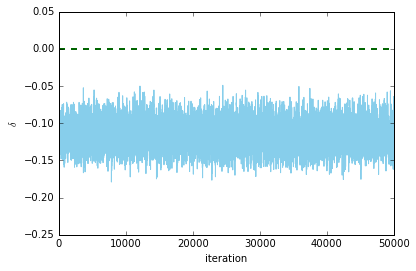

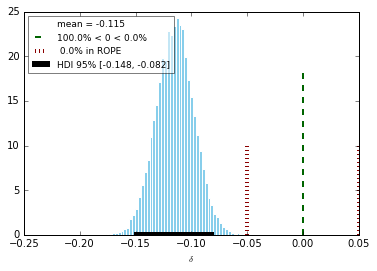

In [27]:
plot_results(comparison_BD, [10], val_lim=[-0.25,0.05], freq_lim=[0,25])

In [82]:
def compute_prior_traces(y_hat_a, y_hat_b):
    prior_traces = []
    for i in range(target_num):
        print(i, end="")
        y_true = np.array(y_tst == i)
        y_pred_a = np.array(y_hat_a == i)
        y_pred_b = np.array(y_hat_b == i)
        model = bpm.build_model_paired(y_true, y_pred_a, y_pred_b, 0)
        trace = bpm.learn_model(model)
        prior_traces.append(trace)
        print()
    return prior_traces

In [83]:
comparison_00 = compute_prior_traces(clf_y_hat[1], clf_y_hat[3])

 [-----------------100%-----------------] 50000 of 50000 complete in 18.2 sec
 [-----------------100%-----------------] 50000 of 50000 complete in 23.8 sec
 [-----------------100%-----------------] 50000 of 50000 complete in 18.8 sec
 [-----------------100%-----------------] 50000 of 50000 complete in 18.4 sec
 [-----------------100%-----------------] 50000 of 50000 complete in 18.4 sec
 [-----------------100%-----------------] 50000 of 50000 complete in 18.4 sec
 [-----------------100%-----------------] 50000 of 50000 complete in 18.4 sec
 [-----------------100%-----------------] 50000 of 50000 complete in 18.4 sec
 [-----------------100%-----------------] 50000 of 50000 complete in 18.4 sec
 [-----------------100%-----------------] 50000 of 50000 complete in 18.3 sec
 [-----------------100%-----------------] 50000 of 50000 complete in 18.5 sec
 [-----------------100%-----------------] 50000 of 50000 complete in 18.5 sec
 [-----------------100%-----------------] 50000 of 50000 complet

In [84]:
def show_bfsd_results(target_traces):
    for i in range(len(target_traces)):
        prio_trace = comparison_00[i]
        post_trace = target_traces[i]
        var = 'delta'
        prio_sample = prio_trace[var]
        post_sample = post_trace[var]
        print("{:d}\t".format(i), end="")
        print("{:s}\t{:.3f}".format(var, bps.bfsd(prio_sample, post_sample, cmp_val=0)))

In [85]:
show_bfsd_results(comparison_AB)

0	delta	0.003
1	delta	0.000
2	delta	0.000
3	delta	0.000
4	delta	0.000
5	delta	0.000
6	delta	0.000
7	delta	0.000
8	delta	0.000
9	delta	0.000
10	delta	0.000
11	delta	0.000
12	delta	0.000
13	delta	0.000
14	delta	0.000
15	delta	3.132
16	delta	0.000
17	delta	0.000
18	delta	0.007
19	delta	2.389


In [87]:
show_bfsd_results(comparison_CD)

0	delta	3.399
1	delta	9.427
2	delta	12.058
3	delta	4.593
4	delta	3.781
5	delta	12.206
6	delta	0.011
7	delta	0.000
8	delta	8.165
9	delta	0.000
10	delta	9.261
11	delta	12.937
12	delta	1.209
13	delta	5.513
14	delta	10.671
15	delta	0.330
16	delta	1.225
17	delta	6.589
18	delta	8.065
19	delta	7.488


In [88]:
show_bfsd_results(comparison_BD)

0	delta	8.542
1	delta	3.128
2	delta	3.739
3	delta	2.966
4	delta	9.533
5	delta	0.075
6	delta	8.805
7	delta	2.566
8	delta	9.551
9	delta	0.000
10	delta	0.000
11	delta	7.016
12	delta	0.008
13	delta	0.004
14	delta	0.194
15	delta	10.473
16	delta	0.650
17	delta	0.058
18	delta	6.927
19	delta	0.825


In [89]:
import bperf_plot as bpp
reload(bpp)

<module 'bperf_plot' from 'c:\\My\\Work\\bperf\\bperf_plot.py'>

In [90]:
%matplotlib inline

In [93]:
import matplotlib.pyplot as plt

def plot_results(target_traces, targets, burn=0, cmp_val=0, rope=[-0.05,0.05], val_lim=[-0.15,0.15], freq_lim=[0,30], bins=50):
    for i in targets:
        trace = target_traces[i]
        sample = trace[burn:]['delta']
        #
        plt.figure()
        bpp.plot_trace(sample, cmp_val=cmp_val, ylab='$\delta$', ylim=val_lim);
        #plt.savefig("../bperf_paper/fig/trace_plot_{:02d}.pdf".format(i))
        #
        plt.figure()
        bpp.plot_post(sample, cmp_val=cmp_val, rope=rope, xlab='$\delta$', xlim=val_lim, ylim=freq_lim, bins=bins);
        #plt.savefig("../bperf_paper/fig/post_plot_{:02d}.pdf".format(i))
        #
        plt.figure()
        prior_trace = comparison_00[i]
        prior_sample = prior_trace[burn:]['delta']
        bpp.plot_bfsd(prior_sample, sample, cmp_val=cmp_val, xlab='$\delta$', xlim=val_lim, ylim=freq_lim)
        #plt.savefig("../bperf_paper/fig/bfsd_plot_{:02d}.pdf".format(i))

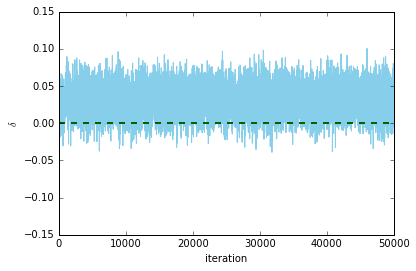

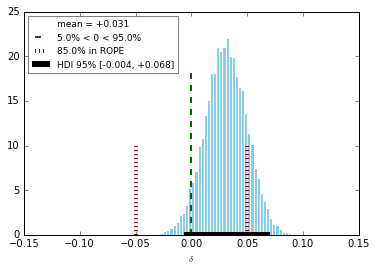

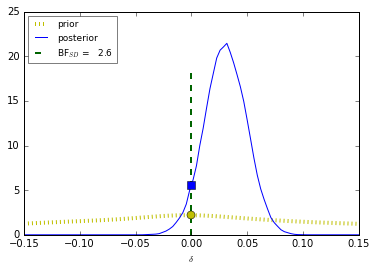

In [94]:
plot_results(comparison_BD,  [7], val_lim=[-0.15,0.15], freq_lim=[0,25])

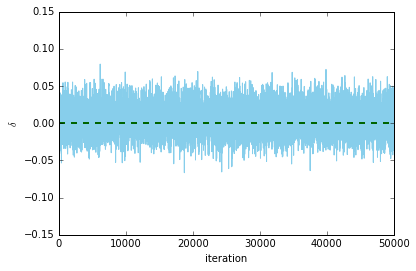

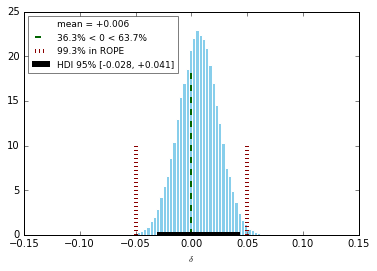

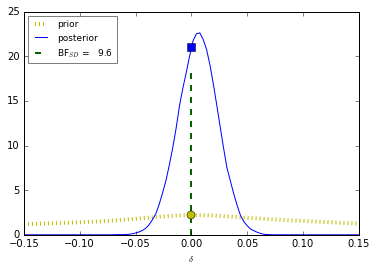

In [95]:
plot_results(comparison_BD,  [8], val_lim=[-0.15,0.15], freq_lim=[0,25])

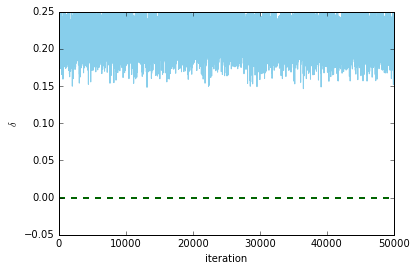

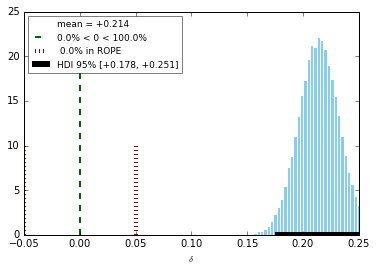

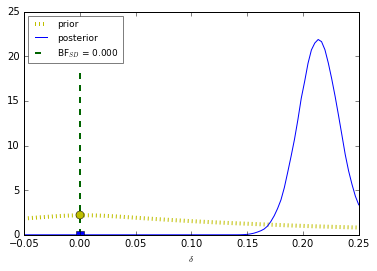

In [96]:
plot_results(comparison_BD,  [9], val_lim=[-0.05,0.25], freq_lim=[0,25])

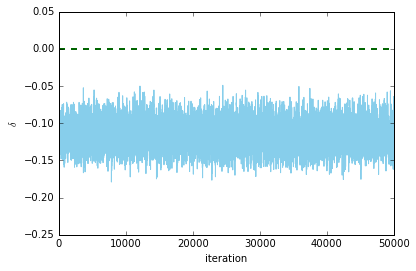

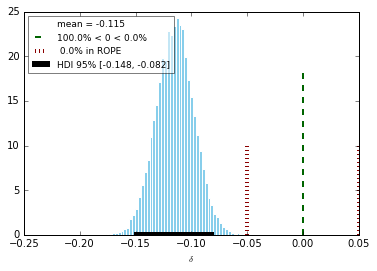

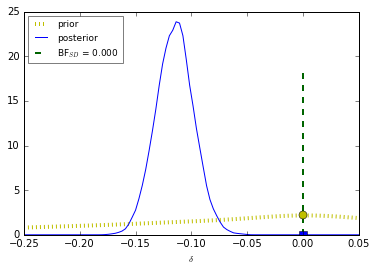

In [97]:
plot_results(comparison_BD, [10], val_lim=[-0.25,0.05], freq_lim=[0,25])

In [99]:
import timeit
start_time = timeit.default_timer()
comparison_BD = compare_classifiers(clf_y_hat[1], clf_y_hat[3])
elapsed = timeit.default_timer() - start_time
print(elapsed/20)

 [-----------------100%-----------------] 50000 of 50000 complete in 18.5 sec
 [-----------------100%-----------------] 50000 of 50000 complete in 18.5 sec
 [-----------------100%-----------------] 50000 of 50000 complete in 19.2 sec
 [-----------------100%-----------------] 50000 of 50000 complete in 19.1 sec
 [-----------------100%-----------------] 50000 of 50000 complete in 19.2 sec
 [-----------------100%-----------------] 50000 of 50000 complete in 19.1 sec
 [-----------------100%-----------------] 50000 of 50000 complete in 18.7 sec
 [-----------------100%-----------------] 50000 of 50000 complete in 18.4 sec
 [-----------------100%-----------------] 50000 of 50000 complete in 18.4 sec
 [-----------------100%-----------------] 50000 of 50000 complete in 18.4 sec
 [-----------------100%-----------------] 50000 of 50000 complete in 18.4 sec
 [-----------------100%-----------------] 50000 of 50000 complete in 19.0 sec
 [-----------------100%-----------------] 50000 of 50000 complet